# Python Lesson 2: Maps and Analysis


## Agenda
1. Creating maps using Cartopy
2. Importing common formats like netCDF and HDF files
3. Common map-related remote sensing tasks


## Basemap is dead &rarr; Use [CartoPy](https://scitools.org.uk/cartopy/)
* CartoPy is not included in Anaconda, need to install yourself.

Open the terminal (\*nix) or Anaconda Prompt (Windows) and type:
```python
conda install -c conda-forge cartopy
```
* Rather than import all of cartopy, we just want the projection classes to pair with matplot lib.
* More [map projections](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html).

In [124]:
import pandas as pd
import numpy as np

# Bring back our list of aeronet stations...
url = 'https://aeronet.gsfc.nasa.gov/aeronet_locations_v3.txt'
stationList = pd.read_csv(url, skiprows=1)
stationList.columns = ['site', 'lon', 'lat', 'elev']

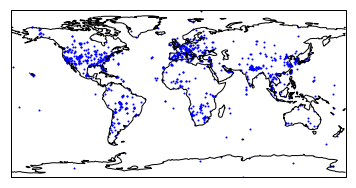

In [125]:
import cartopy.crs as ccrs
# time saver: ccrs will substitute for typing out cartopy.crs
import matplotlib.pyplot as plt
%matplotlib inline

# Center on the Atlantic
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.scatter(stationList['lon'], stationList['lat'], color='blue', s=1)
plt.show()

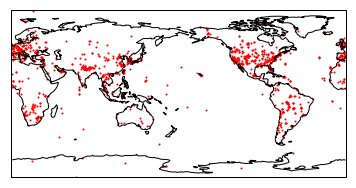

In [126]:
# Center on the Pacific (note the shift in the station longitude as well!)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.coastlines()
plt.scatter(stationList['lon']-180, stationList['lat'], color='red', s=1)
plt.show()

## Plotting satellite datasets

Focusing on 2D only today:
1. Leo
2. Geo

### LEO Example: NOAA-20
Organized in 5 minute swaths

In [127]:
from netCDF4 import Dataset

# Import your data...
file_id = Dataset('data/JRR-AOD_v1r1_npp_s201808091955538_e201808091957180_c201808092049460.nc')
AOD_N20 = file_id.variables['AOD550'][:]
lat = file_id.variables['Latitude'][:]
lon = file_id.variables['Longitude'][:]
file_id.close()

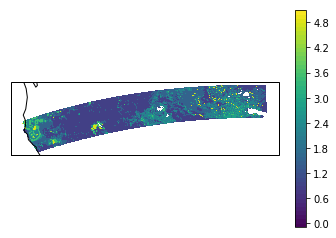

In [128]:
# Using cartopy, create the map projection and plot the data
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lon, lat, AOD_N20, transform=ccrs.PlateCarree())
ax.coastlines()
cb = plt.colorbar(plot)
plt.show()

## Exercise: Plot LEO data

### GEO Example: GOES-17
* Larger imagery, can take a while to load.
* Using CONUS datasets, but Full Disk Imagery is also available


#### Un-scaling the data
* Data are often scaled, so the actual value will be:
\begin{align}
unscaled = value*scalefactor + offset
\end{align}

In [129]:
file_id = Dataset('data/OR_ABI-L2-AODC-M3_G17_s20182211612186_e20182211614557_c20182211615551.nc')
var = file_id.variables['AOD'][:]
value = np.array(var)

# Unscale the data
var_scale_factor = file_id.variables['AOD'].scale_factor
var_offset =  file_id.variables['AOD'].add_offset
AOD_G17 = value*var_scale_factor + var_offset

### GEO Example: GOES-17
#### Georeferencing the data

* GOES makes fixed observations, so the Ful Disk and CONUS files do not contain the lat/lon coordinates to save disc space (Mesoscale does contain lat/lon since the position changes).
* For the details on unscaling the geoference data (e.g. x, y &rarr; lon, lat), see the GOES-16 ATBD or run these scripts.
* For now, I provide the look-up tables so don't worry :-)

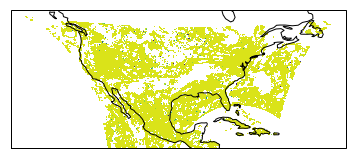

In [130]:
# Import lat/lon from look-up table (code is on GitHub if you want to make your own)
file_id2 = Dataset('data/latlon_L2_G17_CONUS_89W.nc')
lat = file_id2.variables['latitude'][:]
lon = file_id2.variables['longitude'][:]
file_id2.close()

levs = np.arange(0,1,0.1)

# Then you can plot just like before:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lon, lat, AOD_G17, levs, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

## Exercise: Plot Geo data

## Common tasks
1. Masking datasets
2. Regridding
3. Filtering with Quality Flags

### Regridding

There are a few options:
* Interpolate from SciPy package
    * NearestNDInterpolator: Nearest neighbour interpolation on unstructured data in N dimensions
    * LinearNDInterpolator: Piecewise linear interpolant on unstructured data in N dimensions
    * RegularGridInterpolator: Linear and nearest-neighbor Interpolation on a regular grid in arbitrary dimensions
    * RectBivariateSpline: Bivariate spline approximation over a rectangular mesh
* Regridding in iris package (autodetection of GRIB and NC fileformats... if they follow the conventions!)
* ESMF which is a wrapper for xarray (Unix only and kind of new)

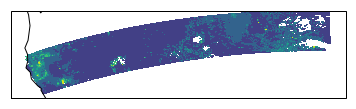

In [118]:
# Simple downscaling: take every other point
lonDownscl=lon[::4,::4]
latDownscl=lat[::4,::4]
AODDownscl=AOD_G17[::4,::4]

ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lonDownscl, latDownscl, AODDownscl, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

NameError: name 'levs' is not defined

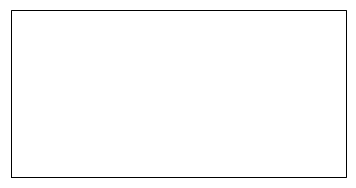

In [122]:
from scipy.interpolate import NearestNDInterpolator

# Fancier: use interpolating functions
# NearestNDInterpolator(grid points, values)
regridAOD = NearestNDInterpolator((lon.flatten(), lat.flatten()), AOD550.flatten())
AODDownscl = regridAOD(lonDownscl.flatten(), latDownscl.flatten())
AODDownscl = AODDownscl.reshape(lonDownscl.shape)

ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lonDownscl, latDownscl, AODDownscl, levs, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

### Masking Datasets

NameError: name 'lev' is not defined

/Users/Rebekah/anaconda/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


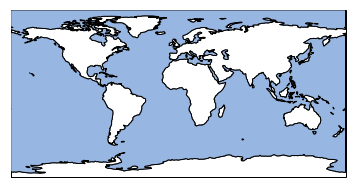

In [123]:
import cartopy.feature as feature

levs = np.arange(0,1,0.1)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Mask out the ocean
ax.add_feature(feature.OCEAN, zorder=100, edgecolor='k')

# Uncomment to show entire globe instead of fitting to the data
#ax.set_global()

plot = ax.contourf(lon, lat, AOD_G17, levs, transform=ccrs.PlateCarree())
cb = plt.colorbar(plot)
plt.show()

### Filtering

In [ ]:
# Import quality flag
DQF = file_id.variables['DQF'][:]
AOD_G17[dqf >=2] = -999.0

# Done with the G17 data
file_id.close()

In [ ]:
# Re-plot only the "high quality" data
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lon, lat, AOD_G17, levs, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

## Saving results

### Saving arrays or pandas dataframes
* I recommend using npz.save(), which will save it in a python-friendly binary format
* Allows faster read later, but cannot visually inspect the files

### Saving as netCDF or HDF
* Steps are similar to how you open the file
* Try to follow [climate and forecast conventions](https://www.unidata.ucar.edu/software/netcdf/conventions.html)

In [ ]:
# Open the dataset in "write mode"
rootgrp = Dataset(name, "w", format="NETCDF4")

# Define the coordinates
latnc = rootgrp.createDimension("lat", lat.shape[0])
lonnc = rootgrp.createDimension("lon", lon.shape[1])

latitudes = rootgrp.createVariable("latitude","f4",("lat","lon"), zlib=True, least_significant_digit=2)
longitudes = rootgrp.createVariable("longitude","f4",("lat","lon"), zlib=True, least_significant_digit=2)

# Define the variable you want to save
variable = rootgrp.createVariable('AOD550', 'f4',("lat","lon"), zlib = True, fill_value = fill_val[var_name])

# Fill in some Metadata
rootgrp.description = "High quality L2 AOD GOES-17 (Test Position)"
latitudes.units = "degrees north"
longitudes.units = "degrees east"
variable.long_name = "Aerosol Optical Depth"
# Harmonized naming for atmospheric parameters: 
# http://cfconventions.org/Data/cf-standard-names/59/build/cf-standard-name-table.html
variable.standard_name = "atmosphere_absorption_optical_thickness_due_to_ambient_aerosol"

# Finally, fill in the variables
variable[:,:,:] = AODQF
latitudes[:,:] = lat
longitudes[:,:] = lon

# If you do not close, the file will not be usable!
rootgrp.close()

## Scripting

* Notebooks are nice for sharing results with others, but scripts are useful for automating tasks.
* To make a script, copy code into a [filename].py file with the following shebang:
```python
#!/usr/bin/env python
```

Then to call the script, open the terminal, check the file permissions, and simply type:
```python
python rgb.py
```
On Windows, you'll need to run the scripts through the Anaconda Prompt.


## Closing up
We'll be around for the next 30 minutes and I am available by email: rebekah.esmaili@gmail.com

When we started, we stated that our goals were to: 

Objective: working with satellite datasets
* You won't learn how to code in Python
	* Some (free!) ways to learn: [automate boring stuff](Automate the Boring Stuff with Python), [codeacademy](https://www.codecademy.com/learn/learn-python), [find Meetups](https://www.meetup.com/find/tech/) or start your own!
* You will learn to:
	* Read/write satellite datasets
	* Plot datasets
	* Perform re-gridding, merging, averaging, filtering

How did we deliver?

## Thank you!
I hope you enjoyed this crash course in python in remote sensing applications! Please fill out feedback, write as much as you can!